**Step 1: Import packages**

In [1]:
# Import libraries
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
import kerastuner as kt
import IPython

# sklearn libraries for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# sklearn libraries for models
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from kerastuner import HyperModel
from kerastuner import Hyperband

# sklearn libraries for evaluation
from sklearn import metrics

**Step 2: Define working directories**

In [ ]:
os.chdir('C:/Users/user/Documents/Berkeley_MIDS/W207_Machine_Learning/w207_final_project')

**Step 3: Define classes**

In [2]:
# Clear the training outputs at the end of every step
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        '''Clear the training outputs at the end of every step for the Keras Tuner'''
        IPython.display.clear_output(wait = True)

**Step 4: Define functions**

In [3]:
def reduce(X, n):
    '''PCA dimensionality reduction for X array and n principal components'''
    ss = StandardScaler()
    XS = ss.fit_transform(X)
    pca = PCA(n_components = n) 
    X_reduced = pca.fit_transform(XS)
    return X_reduced

In [4]:
def data_split(X, y, test_p, mini_s):
    '''Split train and test data for X,y data arrays with test_p percentage of observations in the test data and 
    mini_s number of observations in the mini_train set.'''
    # Split into train and test data
    train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=test_p, random_state=1, stratify=y)

    # Split test data into development data and training into mini train set for computation time
    dev_data, dev_labels = test_data[:int(test_data.shape[0]*0.5)], test_labels[:int(test_data.shape[0]*0.5)]
    mini_train_data, mini_train_labels = train_data[:mini_s], train_labels[:mini_s]
    print('Train data shape:', train_data.shape)
    print('Dev data shape:', dev_data.shape)
    print('Mini_train data shape:', mini_train_data.shape)
    
    return train_data, train_labels, test_data, test_labels, dev_data, dev_labels, mini_train_data, mini_train_labels

In [5]:
def log_reg(train_X, train_Y, dev_X, dev_Y):
    '''Logistic regression looping through values of C. Input train and test data and labels and funtion 
    returns list of accuracies and list of C values.'''
    c_values = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 5.0]
    LR = []
    for c in c_values:
        clf = LogisticRegression(C=c, solver='liblinear', multi_class='auto')
        clf.fit(train_X, train_Y)
        clf_pred = clf.predict(dev_X)
        LR.append(round(metrics.f1_score(dev_Y, clf_pred, average='weighted'),3))

    return LR, c_values

In [6]:
def LR_accuracy_c(train_X, train_Y, dev_X, dev_Y):
    '''Calls logistic regression function and returns highest accuracy for specific value of C.'''
    accuracy_list = log_reg(train_X, train_Y, dev_X, dev_Y)[0]
    accuracy = [y for x,y in sorted(enumerate(accuracy_list), key = lambda x: x[1], reverse=True)][:1]
    accuracy_index = [x for x,y in sorted(enumerate(accuracy_list), key = lambda x: x[1], reverse=True)][:1]
    C = log_reg(train_X, train_Y, dev_X, dev_Y)[1][accuracy_index[0]]
    
    return accuracy[0], C

In [7]:
def PCA_visualization(pca_vals, title, colors):
    x = [item[0] for item in pca_vals] 
    y = [item[1] for item in pca_vals] 

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    ax.scatter(x, y, c=colors, s = 5)
    ax.grid()

In [8]:
def PCA_k_optimize(train_X, train_Y, dev_X, dev_Y, k_list):
    accuracies = []
    c_vals = []
    # Subset pixel data
    train_pixel = train_X[:, :150529]
    dev_pixel = dev_X[:, :150529]
    train_nopixel = train_X[:, 150529:]
    dev_nopixel = dev_X[:, 150529:]
    for k in k_list:
        #Scale and reduce only pixel data
        ss = StandardScaler()
        train_pixel_s = ss.fit_transform(train_pixel)
        dev_pixel_s = ss.transform(dev_pixel)
        pca = PCA(n_components = k) 
        train_pixel_reduced = pca.fit_transform(train_pixel_s)
        dev_pixel_reduced = pca.transform(dev_pixel_s)
        #Concatenate reduced pixel data back with non pixel data
        train_X_new = np.concatenate((train_nopixel, train_pixel_reduced), axis=1)
        dev_X_new = np.concatenate((dev_nopixel, dev_pixel_reduced), axis=1)
        #Obtain accuracy and optimized c value
        results = LR_accuracy_c(train_X_new, train_Y, dev_X_new, dev_Y)
        accuracies.append(results[0])
        c_vals.append(results[1])
    return accuracies, c_vals

In [9]:
def model_builder(hp):
    '''Build a single layer dense neural network using Keras Tuner'''
    model = keras.Sequential()
  
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)

    model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
    
    model.add(keras.layers.Dense(2, activation = 'softmax'))

    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])
  
    return model

In [10]:
def build_model(nodes, dropout_rate, lr):
    '''Build layers of a neural net'''
    
    # Begins the linear arrangment of layers
    model = tf.keras.models.Sequential([

    # First layer 
    # This is a dense layer. Nodes are fully connected.
    # Nodes is the number of nodes in the layer. This will be specified when calling the function.
    tf.keras.layers.Dense(nodes, activation='relu'),

    # Second layer
    # Uses dropout regularization by dropping a certain percentage before next layer
    # This makes it so that some of the nodes in a given layer don’t pass on their information to the next layer. 
    # This helps with computation time (less parameters) and with overfitting.
    # Each node in the second  layer has a probability equal to the specified dropout rate of being dropped from the computation of the activations of the next layer. 
    tf.keras.layers.Dropout(dropout_rate),
    
    # Third layer
    # This is the output layer. It returns a logits array of length 2 (because we have 2 classes - logo or not logo)
    # Each node contains a probability that indicates the current image belongs to one of the 2 classes
    # It uses the activation function Softmax which is the equivalent of the Sigmoid function for multiclass logits
    tf.keras.layers.Dense(2, activation='softmax')])
    
    # Compile the model using the Adam optimizer
    # The learning rate will be specified when the function is called
    model.compile(keras.optimizers.Adam(learning_rate = lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [11]:
# Fit the neural net model
# Specify the number of epochs
def fit_model(model, data, labels, epoch_num):
    history = model.fit(data, labels, epochs = epoch_num)
    return history

In [12]:
# Evaluate the neural net model
def evaluate_model(model, data, labels):
    test_loss, test_acc = model.evaluate(data, labels)
    return test_acc

**Step 5: Read data**

5.1 Load and combine pixel data files into dataframe

In [13]:
# Load npz files to combine and print content files
data_1 = np.load('et_w207_project_npz_files_5000_tmp_tmp5ocrhjnn.npz')
data_1.close

data_2 = np.load('et_w207_project_npz_files_5000_tmp_tmp092sag67.npz')
data_2.close

data_3 = np.load('et_w207_project_npz_files_5000_tmp_tmpf31_pn8p.npz')
data_3.close

data_4 = np.load('et_w207_project_npz_files_5000_tmp_tmpq5b2g4n2.npz')
data_4.close

print(data_1.files)

['arr_0', 'arr_1']


In [14]:
# Show file arr_0 example
data_1['arr_0'][:5]

array(['ozbpir-9ey6js-ggdqwo', '378ykanq', 'p366md-big834-7o23k6',
       '3zruwvl2', 'q18iae-3vnh74-79npmy'], dtype='<U20')

In [15]:
# Show file arr_1 example
data_1['arr_1'][:5]

array([[-103.939   , -116.779   , -123.68    , ..., -103.939   ,
        -116.779   , -123.68    ],
       [ -46.939003,  -74.779   , -118.68    , ...,  -57.939003,
         -84.779   , -118.68    ],
       [ 151.061   ,  138.22101 ,  131.32    , ...,  151.061   ,
         138.22101 ,  131.32    ],
       [  -3.939003,  -66.779   ,  -96.68    , ...,   -3.939003,
         -66.779   ,  -96.68    ],
       [-103.939   , -116.779   , -123.68    , ..., -103.939   ,
        -116.779   , -123.68    ]], dtype=float32)

In [16]:
# Get number of observations in each file
print(data_1['arr_0'].shape)
print(data_2['arr_0'].shape)
print(data_3['arr_0'].shape)
print(data_4['arr_0'].shape)

(878,)
(893,)
(638,)
(1353,)


In [17]:
# Concatenate data from all files
data_key = np.concatenate((data_1['arr_0'], data_2['arr_0'], data_3['arr_0'], data_4['arr_0']))

data_pixel = np.concatenate((data_1['arr_1'], data_2['arr_1'], data_3['arr_1'], data_4['arr_1']))
print(data_pixel.shape)

(3762, 150528)


In [18]:
# Create key value pairs with attachment key and pixel array
# Standardize pixel values between 0 and 1 by dividing by 255
# Store pixel data as dataframe
data_dict = {}
for i in range(data_key.shape[0]):
    data_dict[data_key[i]] = [data_pixel[i]/255]

df_pixel = pd.DataFrame(data=data_dict)
df_pixel_t = df_pixel.transpose()
df_pixel_t.index.names = ['attachment_key']
df_pixel_t.columns = ['pixel_array']
df_pixel_t

,pixel_array
attachment_key,
ozbpir-9ey6js-ggdqwo,"[-0.40760392, -0.45795685, -0.4850196, -0.4076..."
378ykanq,"[-0.18407452, -0.29325098, -0.46541175, -0.097..."
p366md-big834-7o23k6,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
3zruwvl2,"[-0.015447071, -0.26187843, -0.37913725, -0.01..."
q18iae-3vnh74-79npmy,"[-0.40760392, -0.45795685, -0.4850196, -0.4076..."
...,...
pktyig-481wyg-6gyulf,"[-0.3605451, -0.41089803, -0.38305882, -0.3644..."
zu7y3rha,"[-0.007603933, -0.05795686, -0.08501961, -0.00..."
pxcwxf-8tnpyg-8vhb9r,"[0.3022, 0.18125883, 0.12674509, 0.31004313, 0..."


5.2 Load metadata file

In [19]:
# Load excel data
df = pd.read_csv('school_project_data_set-new.csv')
df.head()

,attachment_key,size_mb,height,width,h_to_w,filename,logo
0,001lq61k,0.122520,514.0,720.0,0.713889,campus ministry on the beach.jpg,0
1,002dlirq,3.256944,4072.0,3868.0,1.052741,BIG ALS FISH FLASH UV VP PL.jpg,0
2,003qefgm,0.002522,80.0,200.0,0.400000,netix_email_studio.png,1
3,0083okjl,0.116802,600.0,600.0,1.000000,productshot2.jpg,0
4,00a957mh,0.140714,816.0,2382.0,0.342569,divine_medical_billing_inc_master.png,1


5.3 Combine pixel and metadata features in a pandas dataframe

In [20]:
# Merge dataframes by attachment key
combined_df = df.merge(df_pixel_t, on='attachment_key')
combined_df

,attachment_key,size_mb,height,width,h_to_w,filename,logo,pixel_array
0,00xjny6u,0.011849,520.0,506.0,1.027668,Esterdale Theatre - Logo.png,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
1,04o31jop,0.012610,269.0,396.0,0.679293,BLUE_LOGO.png,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
2,0840h7ox,0.399114,518.0,920.0,0.563044,ZEN_LB-5.jpg,0,"[0.106121555, 0.05576863, 0.052235294, 0.09043..."
3,0awudx2h,0.011226,200.0,200.0,1.000000,article central 200.jpg,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
4,0bb8y85h,0.263813,885.0,800.0,1.106250,1116-100_WGTank_white.jpg,0,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
...,...,...,...,...,...,...,...,...
3750,zu7y3rha,0.147371,498.0,702.0,0.709402,journalism.jpg,0,"[-0.007603933, -0.05795686, -0.08501961, -0.00..."
3751,zuanbsqe,0.580392,206.0,415.0,0.496386,2013 05 26_techstars_id_final_bug solo graysca...,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
3752,zw9234v4,2.021135,1645.0,1450.0,1.134483,SPIN N GLO SILVER WING GPK MY.jpg,0,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
3753,zxfqbfj1,0.012057,36.0,345.0,0.104348,cornerstone web logo medium.png,1,"[-0.40760392, -0.45795685, -0.4850196, -0.4076..."


5.4 Visualizations from Pandas profile

In [21]:
# replace blank cells with NaN 
combined_df.replace('', np.nan, inplace=True)

# select features for summary stats
profile = pandas_profiling.ProfileReport(combined_df[['size_mb', 'height', 'width', 'h_to_w', 'filename', 'logo']]) 
profile.to_notebook_iframe()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


NameError: name 'pandas_profiling' is not defined

From the profile above, we can see that heights, width and h_to_w each has 1 missing data. We need to remove them in the data processing.

**Step 6: Data preprocessing**

6.1 Remove null values

In [21]:
# Remove rows with null values
combined_df = combined_df[combined_df.height.notnull()]
combined_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3754 entries, 0 to 3754
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   attachment_key  3754 non-null   object 
 1   size_mb         3754 non-null   float64
 2   height          3754 non-null   float64
 3   width           3754 non-null   float64
 4   h_to_w          3754 non-null   float64
 5   filename        3754 non-null   object 
 6   logo            3754 non-null   int64  
 7   pixel_array     3754 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 264.0+ KB


6.2 Create file type dummy variables from file name

In [22]:
# Find file types from filename
file_types = []
for item in combined_df['filename']:
    file_types.append(item[-3:].lower())

print(set(file_types))

{'age', 'pig', 'jpe', 'jpg', 'ack', '0mm', 'hot', 'ite', '73e', 'lue', 'png', 'peg'}


In [23]:
# Create list of file types from filename to append to df
filetype_encoding = []
for item in combined_df['filename']:
    if item[-3:].lower() == 'jpg':
        filetype_encoding.append('jpg')
    elif item[-3:].lower() == 'png':
        filetype_encoding.append('png')
    else:
        filetype_encoding.append('other')

In [24]:
# Create df that includes column for file type
combined_df['filetype'] = filetype_encoding
combined_df = combined_df[['attachment_key', 'size_mb', 'height', 'width', 'h_to_w', 'filetype', 'pixel_array', 'filename','logo']]
combined_df.head()
#warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,attachment_key,size_mb,height,width,h_to_w,filetype,pixel_array,filename,logo
0,00xjny6u,0.011849,520.0,506.0,1.027668,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",Esterdale Theatre - Logo.png,1
1,04o31jop,0.012610,269.0,396.0,0.679293,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",BLUE_LOGO.png,1
2,0840h7ox,0.399114,518.0,920.0,0.563044,jpg,"[0.106121555, 0.05576863, 0.052235294, 0.09043...",ZEN_LB-5.jpg,0
3,0awudx2h,0.011226,200.0,200.0,1.000000,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",article central 200.jpg,1
4,0bb8y85h,0.263813,885.0,800.0,1.106250,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",1116-100_WGTank_white.jpg,0


In [25]:
# Get dummies for file type
filetype_dummies = pd.get_dummies(combined_df.filetype)

# add to initial df
combined_df = pd.concat((combined_df, filetype_dummies), axis=1)

# print head of df
combined_df.head()

,attachment_key,size_mb,height,width,h_to_w,filetype,pixel_array,filename,logo,jpg,other,png
0,00xjny6u,0.011849,520.0,506.0,1.027668,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",Esterdale Theatre - Logo.png,1,0,0,1
1,04o31jop,0.012610,269.0,396.0,0.679293,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",BLUE_LOGO.png,1,0,0,1
2,0840h7ox,0.399114,518.0,920.0,0.563044,jpg,"[0.106121555, 0.05576863, 0.052235294, 0.09043...",ZEN_LB-5.jpg,0,1,0,0
3,0awudx2h,0.011226,200.0,200.0,1.000000,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",article central 200.jpg,1,1,0,0
4,0bb8y85h,0.263813,885.0,800.0,1.106250,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",1116-100_WGTank_white.jpg,0,1,0,0


6.3 Scale metadata variables

In [26]:
# Scale continuous feature variables
combined_df['size_mb'] = preprocessing.scale(combined_df['size_mb'])
combined_df['h_to_w'] = preprocessing.scale(combined_df['h_to_w'])
combined_df['height'] = preprocessing.scale(combined_df['height'])
combined_df['width'] = preprocessing.scale(combined_df['width'])

6.4 Create X, y arrays

In [27]:
# Organize df to separate into feature arrays
combined_df = combined_df[['attachment_key', 'pixel_array', 'size_mb', 'h_to_w', 'jpg', 'png', 'other',
                                     'height', 'width', 'logo', 'filetype', 'filename']]
combined_df.head()

,attachment_key,pixel_array,size_mb,h_to_w,jpg,png,other,height,width,logo,filetype,filename
0,00xjny6u,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.366308,0.638439,0,1,0,-0.712708,-0.888611,1,png,Esterdale Theatre - Logo.png
1,04o31jop,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.366187,-0.187892,0,1,0,-0.861519,-0.943446,1,png,BLUE_LOGO.png
2,0840h7ox,"[0.106121555, 0.05576863, 0.052235294, 0.09043...",-0.304882,-0.463630,1,0,0,-0.713894,-0.682232,0,jpg,ZEN_LB-5.jpg
3,0awudx2h,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.366407,0.572811,1,0,0,-0.902427,-1.041152,1,jpg,article central 200.jpg
4,0bb8y85h,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.326343,0.824832,1,0,0,-0.496310,-0.742052,0,jpg,1116-100_WGTank_white.jpg


The following profile shows that logo has high correlation with jpg, png file type. The logo has low correlation with other file types. And now, there is no missing data. We have 3754 total observations now which is 1 less than the previous profile. And this proofs that we have removed the null columns correctly.

In [29]:
# replace blank cells with NaN 
combined_df.replace('', np.nan, inplace=True)

# select features for summary stats
profile = pandas_profiling.ProfileReport(combined_df[['size_mb', 'height', 'width', 'h_to_w', 'jpg', 'png', 'other', 'filename', 'filetype', 'logo']]) 
profile.to_notebook_iframe()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


NameError: name 'pandas_profiling' is not defined

In [28]:
# y array contains logo/not logo binary variable
y = np.array(combined_df.iloc[:, 9])

# X array contains pixel array only
pixel_X = np.array(combined_df['pixel_array'].tolist())
print(pixel_X.shape)


(3754, 150528)


In [30]:
# Reduce dimensionality of pixel array
pixel_reduced = reduce(pixel_X,2)

# Reduce dimensionality of non-pixel data
nopixel_X = np.array(combined_df.iloc[:, 2:9].values)
nopixel_reduced = reduce(nopixel_X,2)

# Reduce dimensionality of pixel and non-pixel data
combined_X = np.concatenate((nopixel_X, pixel_X), axis = 1)
combined_reduced = reduce(combined_X,2)

colors = ['r' if label == 0 else 'g' for label in y]

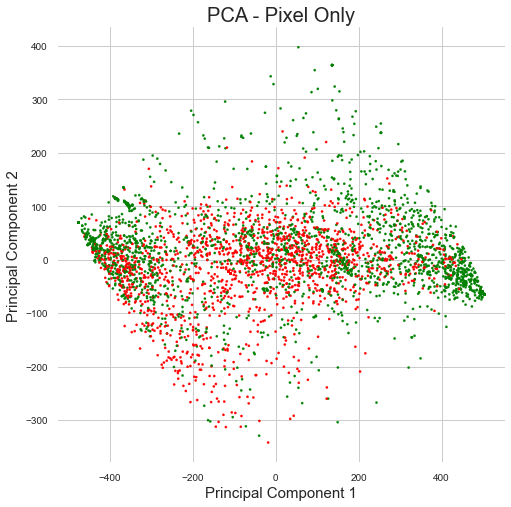

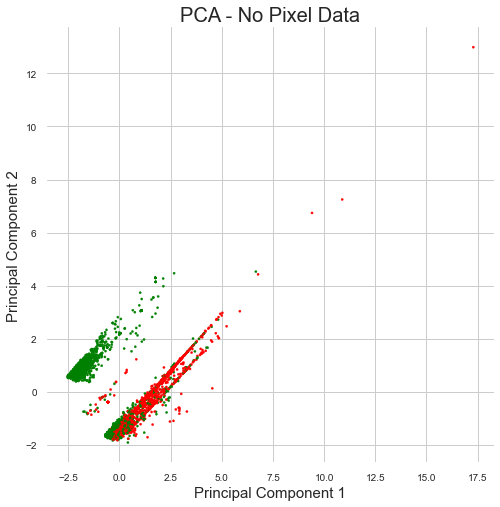

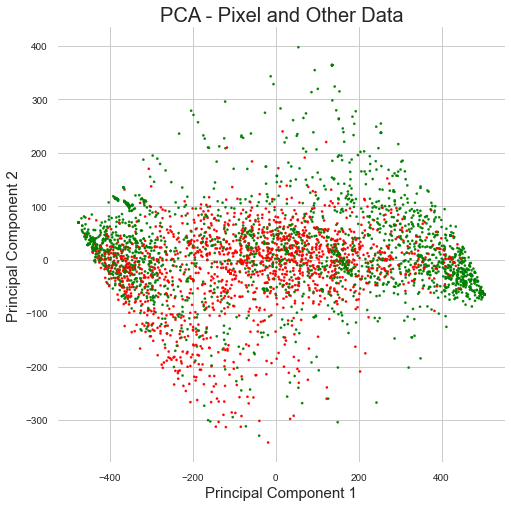

In [31]:
PCA_visualization(pixel_reduced,'PCA - Pixel Only', colors)
PCA_visualization(nopixel_reduced,'PCA - No Pixel Data', colors)
PCA_visualization(combined_reduced,'PCA - Pixel and Other Data', colors)


6.6 Create alternate X arrays with metadata features

In [32]:
# Create variations of X array with reduced pixel data and different metadata features

# X4 array contains size, h_to_w, filetype dummies
X4 = np.array(combined_df.iloc[:, 2:7])
print(X4.shape)

# X5 array contains size, height, width, filetype dummies
X5 = np.array(combined_df.iloc[:, [2,4,5,6,7,8]])
print(X5.shape)

# X6 array contains PCA reduced: full pixel array, size, height, width, h_to_w, filetype dummies
X6 = reduce(np.concatenate((pixel_X, nopixel_X),axis=1),2)
print(X6.shape)

# X7.1 array contains PCA reduced: full pixel array, size, h_to_w, filetype dummies
X71 = reduce(np.concatenate((pixel_X, X4),axis=1),2)
print(X71.shape)

# X7.2 array contains full pixel array, size, height, width, filetype dummies
X72 = reduce(np.concatenate((pixel_X, X5),axis=1),2)
print(X72.shape)

# X8 array contains full pixel array, size, h_to_w, filetype
# Remove height and width for covariance concerns and performance
X8 = np.concatenate((pixel_X, X4), axis=1)
print(X8.shape)

(3754, 5)
(3754, 6)
(3754, 2)
(3754, 2)
(3754, 2)
(3754, 150533)


6.7 Split each set of features into train, development, and test data

In [37]:
# Split all feature combinations into train, test data
# Reduced pixel array only (2 dim)
train_data2, train_labels2, test_data2, test_labels2, dev_data2, dev_labels2, mini_train_data2, mini_train_labels2 = data_split(pixel_reduced, y, 0.4, 100)

# All non-pixel data only
train_data3, train_labels3, test_data3, test_labels3, dev_data3, dev_labels3, mini_train_data3, mini_train_labels3 = data_split(nopixel_X, y, 0.4, 100)

# Only size, h_to_w, filetype dummies
train_data4, train_labels4, test_data4, test_labels4, dev_data4, dev_labels4, mini_train_data4, mini_train_labels4 = data_split(X4, y, 0.4, 100)
# Only size, height, width, filetype dummies
train_data5, train_labels5, test_data5, test_labels5, dev_data5, dev_labels5, mini_train_data5, mini_train_labels5 = data_split(X5, y, 0.4, 100)

# PCA reduction of full pixel array, size, height, width, h_to_w, filetype dummies
train_data6, train_labels6, test_data6, test_labels6, dev_data6, dev_labels6, mini_train_data6, mini_train_labels6 = data_split(X6, y, 0.4, 100)

# PCA reduction of full pixel array, size, h_to_w, filetype dummies
train_data71, train_labels71, test_data71, test_labels71, dev_data71, dev_labels71, mini_train_data71, mini_train_labels71 = data_split(X71, y, 0.4, 100)

# PCA reduction of full pixel array, size, height, width, filetype dummies
train_data72, train_labels72, test_data72, test_labels72, dev_data72, dev_labels72, mini_train_data72, mini_train_labels72 = data_split(X72, y, 0.4, 100)

# Full pixel array with size, h_to_w, filetype
train_data8, train_labels8, test_data8, test_labels8, dev_data8, dev_labels8, mini_train_data8, mini_train_labels8 = data_split(X8, y, 0.4, 100)

Train data shape: (2252, 2)
Dev data shape: (751, 2)
Mini_train data shape: (100, 2)
Train data shape: (2252, 7)
Dev data shape: (751, 7)
Mini_train data shape: (100, 7)
Train data shape: (2252, 5)
Dev data shape: (751, 5)
Mini_train data shape: (100, 5)
Train data shape: (2252, 6)
Dev data shape: (751, 6)
Mini_train data shape: (100, 6)
Train data shape: (2252, 2)
Dev data shape: (751, 2)
Mini_train data shape: (100, 2)
Train data shape: (2252, 2)
Dev data shape: (751, 2)
Mini_train data shape: (100, 2)
Train data shape: (2252, 2)
Dev data shape: (751, 2)
Mini_train data shape: (100, 2)
Train data shape: (2252, 150533)
Dev data shape: (751, 150533)
Mini_train data shape: (100, 150533)


**Step 7: Logistic Regression**

7.1 Run logistic regression for pixel data only

In [38]:
# Pixel array only
# Run LR and output best accuracy with c value
pixel_array_only_LR = LR_accuracy_c(train_data2, train_labels2, dev_data2, dev_labels2)
print('Features: pixel features only\nBest Accuracy: {}, c={}'.format(pixel_array_only_LR[0], pixel_array_only_LR[1]))

Features: pixel features only
Best Accuracy: 0.583, c=0.001


7.2 Run logistic regression for metadata only: use combinations of height and width vs. aspect ratio

In [39]:
all_md_LR = LR_accuracy_c(train_data3, train_labels3, dev_data3, dev_labels3)
h_w_LR = LR_accuracy_c(train_data5, train_labels5, dev_data5, dev_labels5)
htw_LR = LR_accuracy_c(train_data4, train_labels4, dev_data4, dev_labels4)

print('Features: size, height, width, h_to_w, filetype dummies\nBest Accuracy: {}, c={}'.format(all_md_LR[0], all_md_LR[1]))
print('Features: size, height, width, filetype dummies\nBest Accuracy: {}, c={}'.format(h_w_LR[0], h_w_LR[1]))
print('Features: size, h_to_w, filetype dummies\nBest Accuracy: {}, c={}'.format(htw_LR[0], htw_LR[1]))

Features: size, height, width, h_to_w, filetype dummies
Best Accuracy: 0.845, c=0.1
Features: size, height, width, filetype dummies
Best Accuracy: 0.846, c=0.1
Features: size, h_to_w, filetype dummies
Best Accuracy: 0.849, c=0.01


Clearly, the metadata widely outperforms pixel data, so next we tried incorporating the metadata and reducing to two dimensions using PCA. We then ran logistic regressions on this data.

7.3 Run logistic regression for 2 dimension PCA reduced data including pixel array and metadata

In [41]:
PCA_all_LR = LR_accuracy_c(train_data6, train_labels6, dev_data6, dev_labels6)
PCA_h_w_LR = LR_accuracy_c(train_data71, train_labels71, dev_data71, dev_labels71)
PCA_htw_LR = LR_accuracy_c(train_data72, train_labels72, dev_data72, dev_labels72)

print('Features: PCA reduction of size, height, width, h_to_w, filetype dummies\nBest Accuracy: {}, c={}'.format(PCA_all_LR[0], PCA_all_LR[1]))
print('Features: PCA reduction of size, height, width, filetype dummies\nBest Accuracy: {}, c={}'.format(PCA_h_w_LR[0], PCA_h_w_LR[1]))
print('Features: PCA reduction of size, h_to_w, filetype dummies\nBest Accuracy: {}, c={}'.format(PCA_htw_LR[0], PCA_htw_LR[1]))

Features: PCA reduction of size, height, width, h_to_w, filetype dummies
Best Accuracy: 0.583, c=0.001
Features: PCA reduction of size, height, width, filetype dummies
Best Accuracy: 0.583, c=0.001
Features: PCA reduction of size, h_to_w, filetype dummies
Best Accuracy: 0.583, c=0.001


7.4 Use PCA dimension reduction on pixel data only and run logistic regression on reduced pixel array + original metadata

Similar to the PCA visualizations above, the pixel data overwhelms the metadata when both are included in PCA reduction, and the accuracy of these models is quite low. Because of this, we decided to use PCA reduction on _only_ the pixel data, and append that dimension-reduced pixel data to the existing metadata. The existing metadata included in these models were size, aspect ratio, and the filetype dummies, as these features generally performed best. We used a loop to determine the optimal k value for PCA reduction on pixel data, which ended up to be k=1. Accuracy with this model was the highest of any logistic regression model, at 86.1%. As shown in the final chart, reducing the pixel data to any dimensions (up to 15) increases model performance from 58.3% to around 84-85%, but only the k=1 model truly out-performed the previous metadata-only models

In [42]:
#Determine optimal k value for PCA of pixel data
k_list = [i for i in range(1,15)]
logreg_results = PCA_k_optimize(train_data8, train_labels8, dev_data8, dev_labels8, k_list)
accuracies = logreg_results[0]
c_vals = logreg_results[1]
max_index = accuracies.index(max(accuracies))
max_acc = accuracies[max_index]
max_c = c_vals[max_index]
max_k = k_list[max_index]
print('Features: pixel array reduced to {0} dimensions, size, h_to_w, filetype\nBest Accuracy: {1}, c={2}\n'.format(max_k, max_acc, max_c))

Features: pixel array reduced to 1 dimensions, size, h_to_w, filetype
Best Accuracy: 0.861, c=0.1



In [44]:
# Create new train/test data with optimized k value for pixel data
reduce_pixel_k = reduce(pixel_X, max_k)

X9 = np.concatenate((reduce_pixel_k, X4), axis=1)
print(X9.shape)
train_data9, train_labels9, test_data9, test_labels9, dev_data9, dev_labels9, mini_train_data9, mini_train_labels9 = data_split(X9, y, 0.4, 100)

(3754, 6)
Train data shape: (2252, 6)
Dev data shape: (751, 6)
Mini_train data shape: (100, 6)


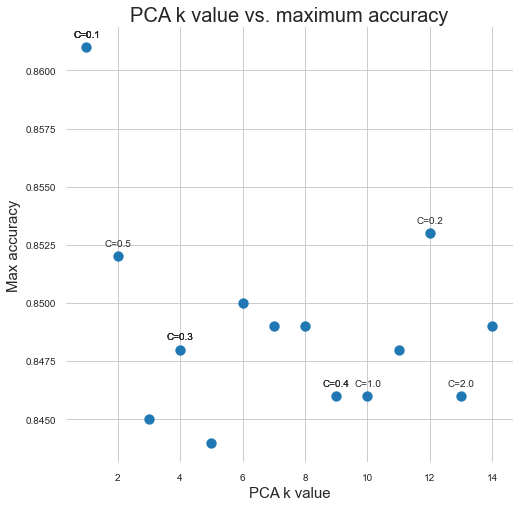

In [47]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PCA k value', fontsize = 15)
ax.set_ylabel('Max accuracy', fontsize = 15)
ax.set_title("PCA k value vs. maximum accuracy", fontsize = 20)
ax.scatter(k_list, accuracies, s = 100)
for c in c_vals:
    plt.annotate("C={}".format(c), (k_list[c_vals.index(c)], accuracies[c_vals.index(c)]), textcoords="offset points", xytext=(0,10), ha='center')
ax.grid()

**Step 8: Multilayer NN**

8.1 Build a single-layer dense neural network using Keras Tuner so that we can easily tune the hyperparameters.

In [ ]:
# Instantiate the tuner to perform hypertuning using the Hyperband tuner and the model_builder function we defined initially.
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'C:/Users/user/Documents/Berkeley_MIDS/W207_Machine_Learning/w207_final_project',
                     project_name = 'keras_tuner_results')    

In [ ]:
# Run the hyperparameter search
tuner.search(train_data9, train_labels9, epochs = 10, validation_data = (dev_data9, dev_labels9), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Print the results
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.fit(train_data9, train_labels9, epochs = 10, validation_data = (dev_data9, dev_labels9))

8.2 Build a multi-layer dense neural network.

In [ ]:
# Run an intial model using the parameters from the Keras Tuner model and an intial dropout rate of .2
build_model_output = build_model(384, .2, .001)
fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 50)
final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
print(final_accuracy)

8.3 Tune the hyperparameters to try and improve the accuracy.

In [ ]:
# Optimize dropout rate
# Loop through dropout rates
dropout_list = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
final_accuracy_dropout_list = []

for i in dropout_list:
    build_model_output = build_model(384, i, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_dropout_list.append(final_accuracy)

In [ ]:
# Graph results
plt.plot(dropout_list, final_accuracy_dropout_list, marker = ".")
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy')

In [ ]:
# Looks like best dropout rate is .4, so now we will use this
# Run model using optimized dropout rate
build_model_output = build_model(384, .4, .001)
fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 50)
final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
print(final_accuracy)

In [ ]:
# Optimize learning rate
# Loop through learning rates
learning_rate_list = [.000001, .00001, .0001, .001, .01, .1]
final_accuracy_learning_list = []

for i in learning_rate_list:
    build_model_output = build_model(384, .4, i)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_learning_list.append(final_accuracy)

In [ ]:
# Graph results
plt.plot(learning_rate_list, final_accuracy_learning_list, label = "Predicted Accuracies", marker = ".")
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

In [ ]:
# Looks like best learning rate is .001, so now we will use this
# Run model using learning dropout rate
build_model_output = build_model(384, .4, .001)
fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 50)
final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
print(final_accuracy)

In [ ]:
# Try different numbers of nodes - keeping dropout at .3 and learning rate at .001

#Loop through nodes
final_accuracy_node_list = []

for i in range(1, 550, 50):
    build_model_output = build_model(i, .4, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_node_list.append(final_accuracy)

In [ ]:
#Graph the results
plt.plot(range(1,550,50), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [ ]:
# It looks like best value is somewhere between 300 and 450
# Narrow this down
# Loop through nodes
final_accuracy_node_list = []

for i in range(300, 450, 25):
    build_model_output = build_model(i, .4, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_node_list.append(final_accuracy)

In [ ]:
#Graph results
plt.plot(range(300, 450, 25), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [ ]:
# It looks like best value is somewhere between 375 and 425
# Narrow this down
# Loop through nodes
final_accuracy_node_list = []

for i in range(375, 425, 10):
    build_model_output = build_model(i, .4, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_node_list.append(final_accuracy)


In [ ]:
#Graph results
plt.plot(range(375, 425, 10), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [ ]:
# It looks like best value is somewhere between 400 and 410
# Narrow this down
# Loop through nodes
final_accuracy_node_list = []

for i in range(400, 410, 1):
    build_model_output = build_model(i, .4, .001)
    fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 10)
    final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
    final_accuracy_node_list.append(final_accuracy)

In [ ]:
#Graph results
plt.plot(range(400, 410, 1), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [ ]:
#Best value is 400. Re-run model with this value and 50 epochs, since we have tuned all the parameters.
build_model_output = build_model(400, .4, .001)
fit_model_output = fit_model(build_model_output, train_data9, train_labels9, 50)
final_accuracy = evaluate_model(build_model_output, dev_data9, dev_labels9)
print(final_accuracy)

In [ ]:
# Plot training cost and accuracy
hist = fit_model_output.history
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss (cost)', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

**Conclusions**